In [141]:
from backend.discover.refinement_checker import Reducer
from data_loader import Data_Loader
import pm4py

num = 1
path = f'/Users/philippeichhorn/Downloads/Compositional process discovery_experiment data/IP-{num}/IP-{num}_initial_log.xes'
list_of_nets = Data_Loader.create_petri_nets(path)


parsing log, completed traces :: 100%|██████████| 5000/5000 [00:09<00:00, 536.17it/s]


In [142]:
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.petri_net.utils import petri_utils

def remove_local_transition(net, transition):
    if len(transition.in_arcs) == 1 and len(transition.out_arcs) == 1:
        place_before_transition = list(transition.in_arcs)[0].source  # will be removed
        if len(place_before_transition.in_arcs) == 1 and len(place_before_transition.out_arcs) == 1:
            first_transition = list(place_before_transition.in_arcs)[0].source  # will point to last place
            place_after_transition = list(transition.out_arcs)[0].target #gets pointed from first_transition
            if (len(place_after_transition.in_arcs)== 1):
                petri_utils.add_arc_from_to(first_transition, place_after_transition, net)
                petri_utils.remove_transition(net, transition)
                petri_utils.remove_place(net, place_before_transition)
                print("removing local transition: ", transition.label)
                return True

    return False
def remove_transition(net, transition):
    #check if current transition has one in on out arc (might not be sufficient todo check)
    # find a t1 
    for other_trans in net.transitions:
        if (other_trans.in_arcs == transition.in_arcs and other_trans.out_arcs == transition.out_arcs and transition != other_trans):
            petri_utils.remove_transition(net, transition)
            print("removing transition: ", transition.label)
            return True
    return False


def remove_place(net, place):
    for other_place in net.places:
        if(set(arc.source for arc in other_place.in_arcs) == set(arc.source for arc in place.in_arcs) and set(arc.target for arc in other_place.out_arcs) == set(arc.target for arc in place.out_arcs) and place != other_place):
            petri_utils.remove_place(net, place)
            print("remove place: ", [in_arcs.source.label for in_arcs in place.in_arcs],  [out_arcs.target.label for out_arcs in place.out_arcs])
            return True
    return False


def place_merge(net, place):
    for other_place in net.places:
        
        #4th no shared transitions before = the sets of transitions prior to p1 and p2 are two disjoint sets
        if (len((set(arc.source for arc in other_place.in_arcs)).intersection(set(arc.source for arc in place.in_arcs))) == 0):
            #6TH:
            set_of_places_to_t3_1 = set()
            set_of_places_to_t3_2 = set()
            for x in set(arc.target for arc in place.out_arcs):
                set_of_places_to_t3_1 = set_of_places_to_t3_1.union(set(arc.source for arc in x.in_arcs))
            for x in set(arc.target for arc in other_place.out_arcs):
                set_of_places_to_t3_1 = set_of_places_to_t3_1.union(set(arc.source for arc in x.in_arcs))
                    
            if set_of_places_to_t3_1 == set_of_places_to_t3_2:  # Compare sets directly
                petri_utils.remove_place(net, place)
                print("merging place: ", [in_arcs.source.label for in_arcs in place.in_arcs],  [out_arcs.target.label for out_arcs in place.out_arcs])
                return True

    return False

In [145]:
import pm4py.objects.petri_net.utils as pnutils
from pm4py.objects.petri_net.obj import PetriNet


class InteractionUtils:

    @staticmethod
    def connect_async_interactions(net):
        for trans in net.transitions:
            if trans.label and "!" in trans.label:
                
                search = trans.label.replace('!', '?')
                print(search)
                for trans2 in net.transitions:
                    if trans2.label == search:
                        print("found matching")
                        new_place = pnutils.petri_utils.add_place(net, "async")
                        pnutils.petri_utils.add_arc_from_to(trans, new_place,
                                                            net)
                        pnutils.petri_utils.add_arc_from_to(new_place, trans2,
                                                            net)

    @staticmethod
    def merge_two_nets(a, b):
        first, c,c  = a
        second, c,c  = b

        merged_net = pnutils.petri_utils.merge(nets=[first,second])
        pm4py.view_petri_net(merged_net, )
        InteractionUtils.connect_async_interactions(merged_net)
        pm4py.view_petri_net(merged_net)
        return merged_net



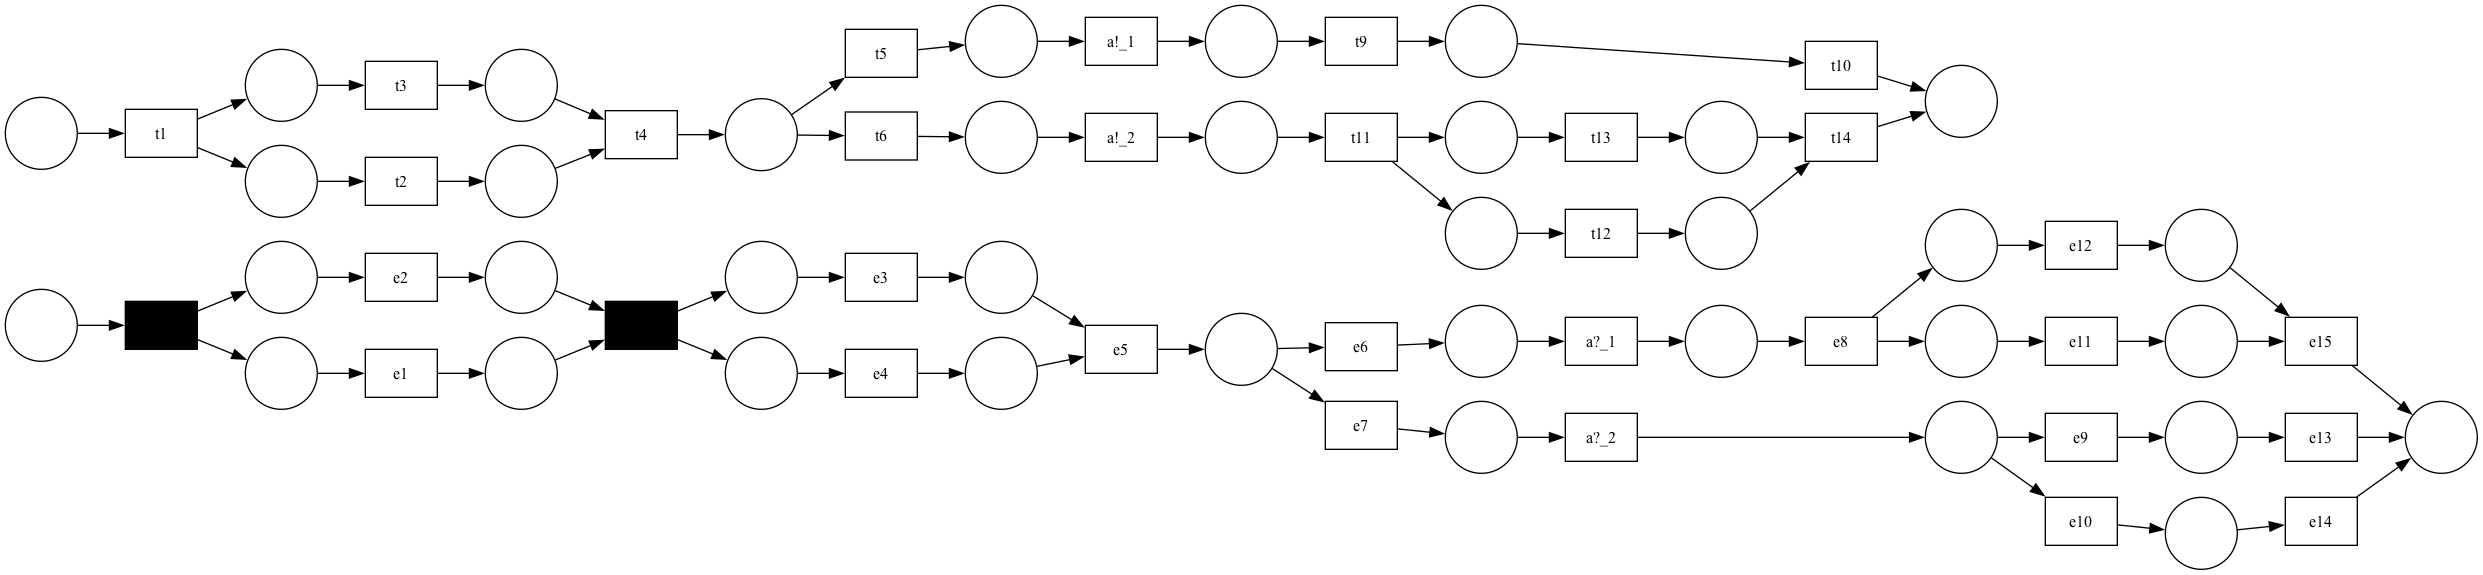

a?_2
found matching
a?_1
found matching


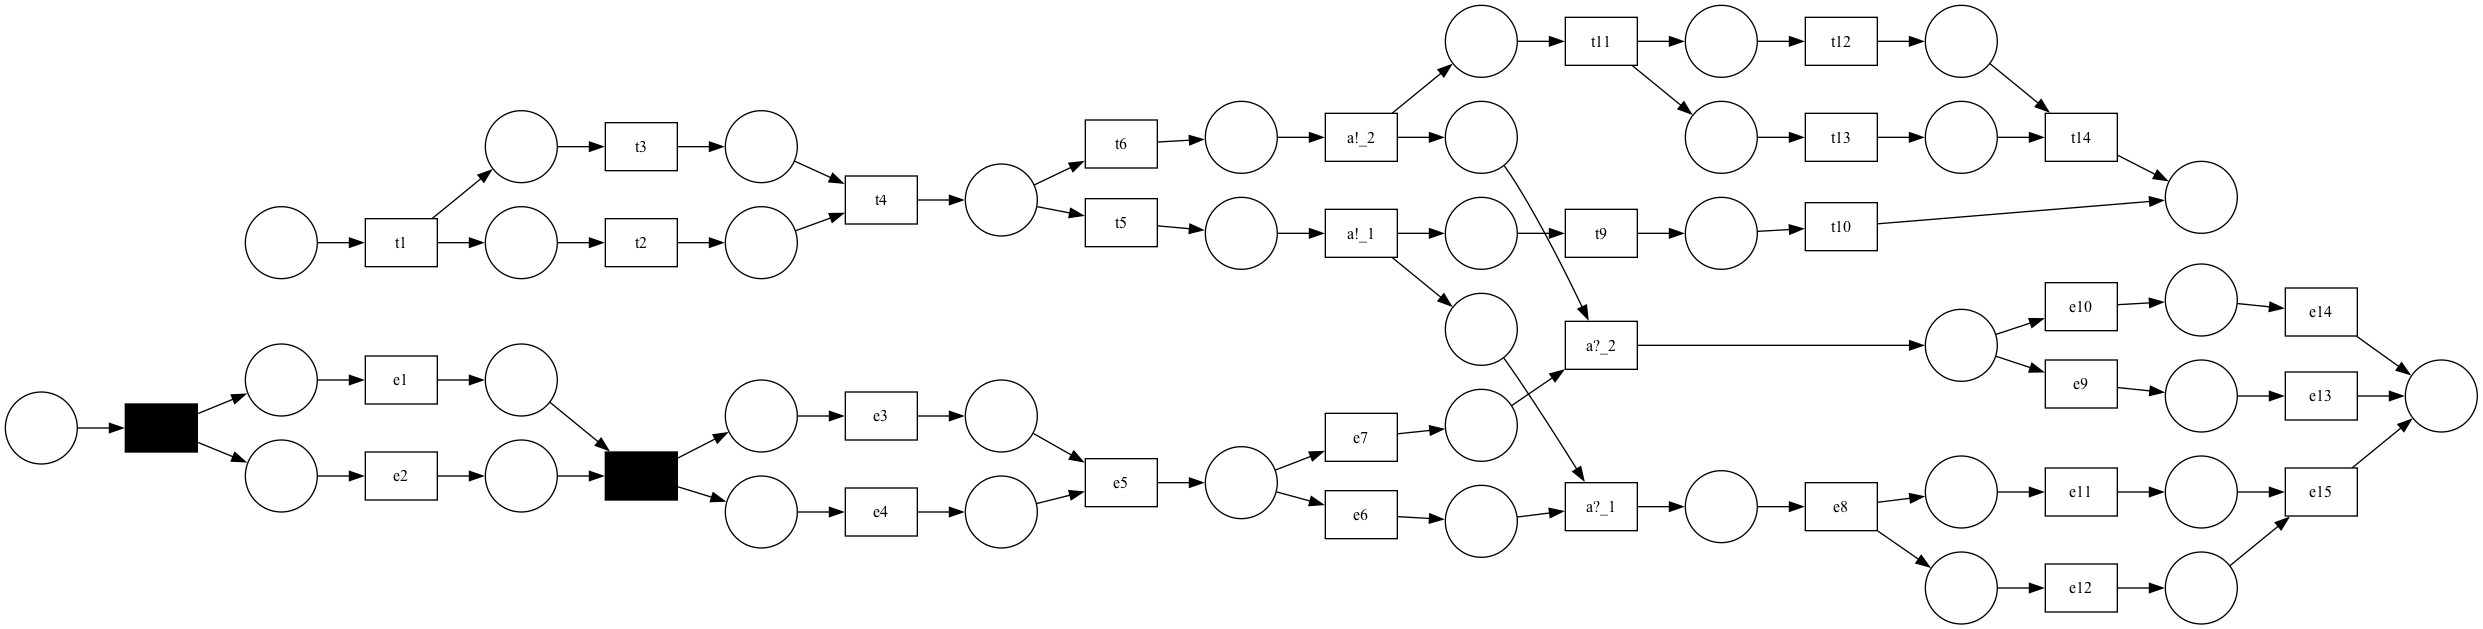

removing local transition:  e2
removing local transition:  t2
removing local transition:  t13
removing local transition:  e3
removing local transition:  t9
removing local transition:  t12
removing local transition:  e4
removing local transition:  e12
removing local transition:  e11
removing local transition:  t3
removing local transition:  e1
remove place:  [None] [None]
remove place:  ['t1'] ['t4']
remove place:  [None] ['e5']
remove place:  ['t11'] ['t14']
remove place:  ['e8'] ['e15']
removing local transition:  e8
removing local transition:  t4
removing local transition:  None
removing local transition:  t11
removing local transition:  e5
All iterations completed, and no function returned True in the last cycle.


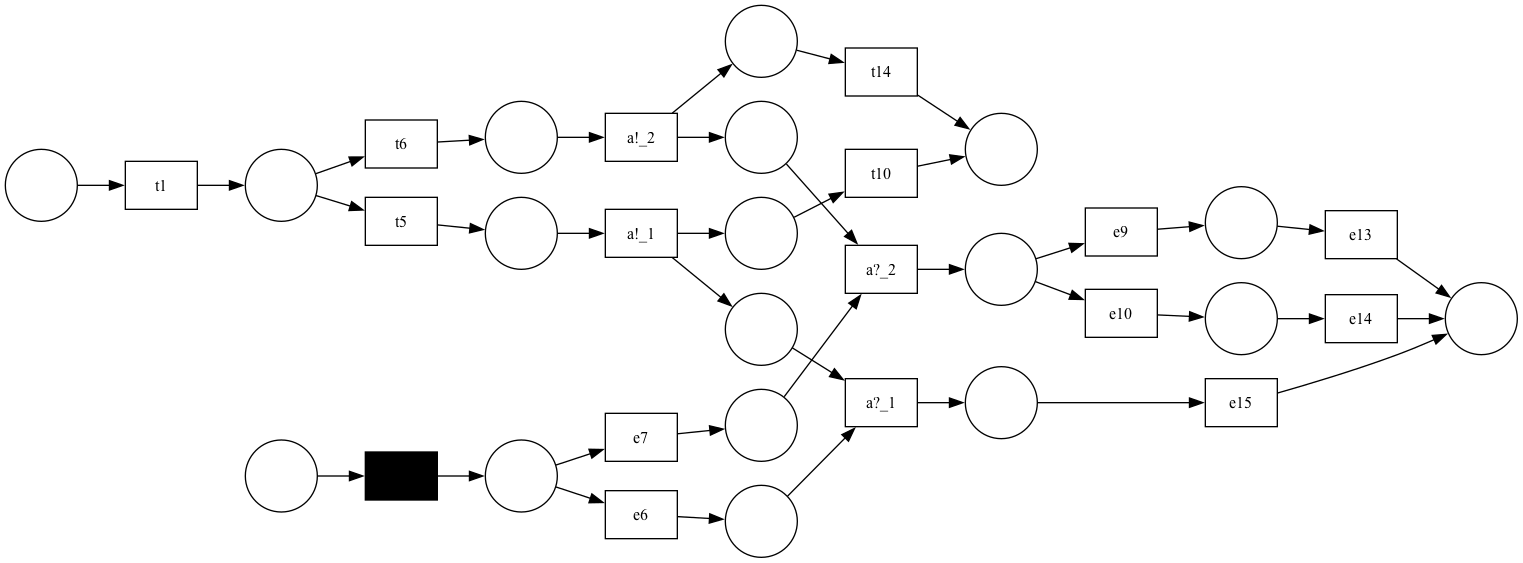

In [149]:
from refinement_checker import Reducer

net = InteractionUtils.merge_two_nets(list_of_nets[0], list_of_nets[1])



# This loop will continue until all functions return False
while True:
	found_true = False

	for place in net.places.copy():
		if remove_place(net, place):
			found_true = True


	for transition in net.transitions.copy():
		if remove_transition(net, transition):
			found_true = True

	for transition in net.transitions.copy():
		if remove_local_transition(net, transition):
			found_true = True


	# If no function returned True, exit the loop
	if not found_true:
		break

print("All iterations completed, and no function returned True in the last cycle.")

              
  

pm4py.view_petri_net(net)
